In [2]:
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
from scipy.stats import norm
from scipy.stats import median_abs_deviation
from scipy.optimize import curve_fit

from astropy.io import fits
import astropy.units as u
from astropy.visualization import quantity_support
from astropy.cosmology import Planck18_arXiv_v2

from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn import mixture
from sklearn.neighbors import KernelDensity

from astroML.linear_model import PolynomialRegression

import pandas as pd

import glob

rc = {"font.family" : "serif", 
      "mathtext.fontset" : "cm",
      "font.size" : "14",
      "figure.figsize" : [10,5]}
plt.rcParams.update(rc)

%config InlineBackend.figure_format='retina'

In [3]:
#reading file

mwsc = 'browse_results.fits'

file = fits.open(mwsc)
data_mwsc = file[1].data
header_mwsc = file[1].header
file.close()

In [4]:
header_mwsc


XTENSION= 'TABLE   '           / ASCII table extension                          
BITPIX  =                    8 / Mandatory value                                
NAXIS   =                    2 / Mandatory value                                
NAXIS1  =                   84 / Length of row                                  
NAXIS2  =                 1000 / Number of rows                                 
PCOUNT  =                    0 / Mandatory value                                
GCOUNT  =                    1 / Mandatory value                                
TFIELDS =                    9 / Number of fields                               
                                                                                
EXTNAME = 'MWSC'               / Extension name                                 
TABLE   = 'heasarc_mwsc'       / Table designation                              
TAB_DESC= 'Milky Way Star Clusters Catalog'                                     
TAB_URL = 'https://heasarc.g

In [5]:
mask = (data_mwsc.field('DEC')>35) & (data_mwsc.field('DEC')<60) & (data_mwsc.field('RA')>15) & (data_mwsc.field('RA')<41) & (data_mwsc.field('CLUSTER_RADIUS')<0.22) & (data_mwsc.field('CLUSTER_RADIUS')>0.1) & (data_mwsc.field('LOG_AGE')<7.5)  

new_data_mwsc = data_mwsc[mask]

In [6]:
print(new_data_mwsc.field('NAME').shape)
print(new_data_mwsc)

(2,)
[('ASCC 7', 29.775, 58.925, 0.18, -49.0, 10.0, 2000.0, 7.4, 0.0)
 ('FSR 0614', 40.62, 56.735, 0.13, 0.0, 0.0, 2787.0, 6.75, 0.0)]


In [7]:
print(new_data_mwsc.field('NAME').shape)
print(new_data_mwsc)

(2,)
[('ASCC 7', 29.775, 58.925, 0.18, -49.0, 10.0, 2000.0, 7.4, 0.0)
 ('FSR 0614', 40.62, 56.735, 0.13, 0.0, 0.0, 2787.0, 6.75, 0.0)]


# NGC956

In [8]:
#NGC catalogue

NGC = 'NGC_catalog.fits'

file = fits.open(NGC)
data_NGC = file[1].data
header_NGC = file[1].header
file.close()

In [9]:
header_NGC

XTENSION= 'TABLE   '           / Ascii Table Extension                          
BITPIX  =                    8 / Character data                                 
NAXIS   =                    2 / Simple 2-D matrix                              
NAXIS1  =                  224 / Number of bytes per record                     
NAXIS2  =                 4669 / Number of records                              
PCOUNT  =                    0 / Get rid of random parameters                   
GCOUNT  =                    1 / Only one group (isn't it obvious?)             
TFIELDS =                   27 / Number of data fields (columns)                
EQUINOX =               2000.0 / Equinox of coordinates (J system)              
EPOCH   =               2000.0 / Epoch of coordinates                           
EXTNAME = 'stars_q2/*'         / *Star catalogs for 650 sky areas               
COMMENT  Note on stars_q2/*: The file names include the MWSC sequential number  
         and a name of a clu

In [10]:
data_NGC.field('Vmag    ')

array([  9.357,   9.75 ,   8.253, ..., -99.99 , -99.99 , -99.99 ])

In [11]:
mask_V = data_NGC.field('Vmag    ')>-99.99

new_NGC_data = data_NGC[mask_V]
V_ordered = np.sort(new_NGC_data.field('Vmag    '))
print(V_ordered)
print(np.mean(V_ordered))

[ 8.253  8.424  8.684 ... 19.2   19.3   19.3  ]
16.188251924063625


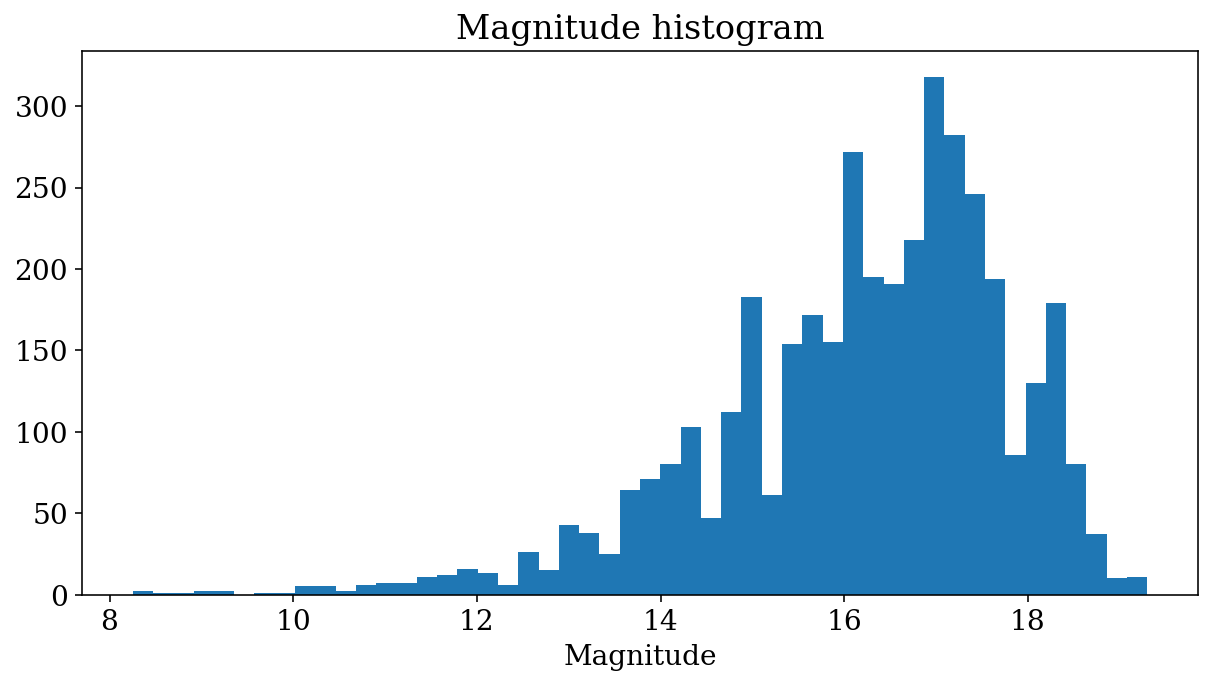

In [12]:
plt.hist(new_NGC_data.field('Vmag    '), bins=50)
plt.title('Magnitude histogram')
plt.xlabel('Magnitude')
plt.show()

Compute the ADU/s rate

In [13]:
#functions

In [14]:
def flux_nu(m): 
    return 10**(-m/2.5) * 3631 #Jy
    

def flux_lambda (m):
    return flux_nu(m) / (3.34*10**4) / (5008)**2

def electron_rate_ADU(m):
    C_Ha = 15.39
    C_OII = 15.28
    C_SII = 15.47
    
    return flux_lambda(m) * 10**C_Ha  / (0.6)

In [15]:
m_max = 8.253
m_avg = 16.2

## Compute SNR

### Max brightness

In [16]:
S = electron_rate_ADU(m_max)
print(S)

8863.390655116204


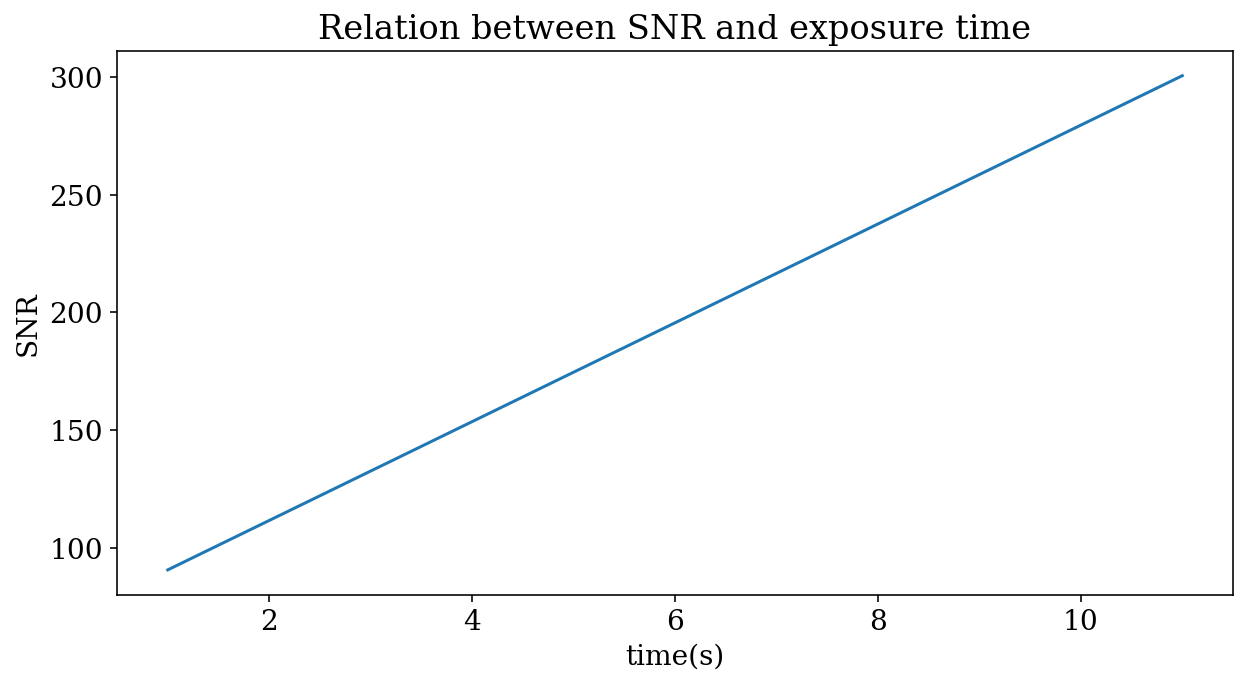

In [17]:
t=np.arange(1, 15, 10)
n = 2.333 * 10**3   # number of pixels covered by our source 
S_B = 0.1            # sky brightness
C_D = 0.2

SNR = S*t / np.sqrt(S*t + n*t*(S_B + C_D))

plt.xlabel('time(s)')
plt.ylabel('SNR')
plt.title('Relation between SNR and exposure time')
plt.plot(t, SNR)


### Average magnitude

In [18]:
S = electron_rate_ADU(m_avg)
print(S)

5.872187190132193


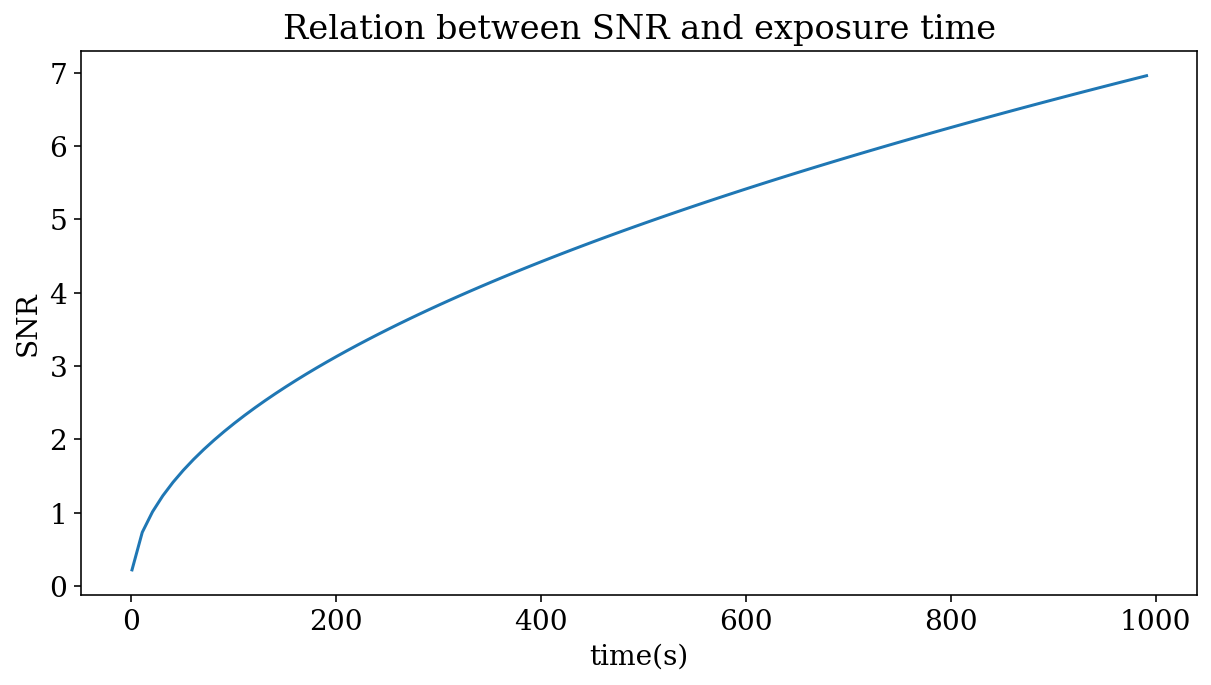

In [19]:
t=np.arange(1, 1000, 10)
n = 2.333 * 10**3   # number of pixels covered by our source 
S_B = 0.1            # sky brightness
C_D = 0.2

SNR = S*t / np.sqrt(S*t + n*t*(S_B + C_D))

plt.xlabel('time(s)')
plt.ylabel('SNR')
plt.title('Relation between SNR and exposure time')
plt.plot(t, SNR)

# FSR0614

In [20]:
#FSR catalogue

FSR = 'FSR_catalog.fits'

file = fits.open(FSR)
data_FSR = file[1].data
header_FSR = file[1].header
file.close()

In [21]:
header_FSR

XTENSION= 'TABLE   '           / Ascii Table Extension                          
BITPIX  =                    8 / Character data                                 
NAXIS   =                    2 / Simple 2-D matrix                              
NAXIS1  =                  224 / Number of bytes per record                     
NAXIS2  =                10348 / Number of records                              
PCOUNT  =                    0 / Get rid of random parameters                   
GCOUNT  =                    1 / Only one group (isn't it obvious?)             
TFIELDS =                   27 / Number of data fields (columns)                
EQUINOX =               2000.0 / Equinox of coordinates (J system)              
EPOCH   =               2000.0 / Epoch of coordinates                           
EXTNAME = 'stars_q2/*'         / *Star catalogs for 650 sky areas               
COMMENT  Note on stars_q2/*: The file names include the MWSC sequential number  
         and a name of a clu

In [22]:
mask_V = data_FSR.field('Vmag    ')>-99.99

new_FSR_data = data_FSR[mask_V]
V_ordered = np.sort(new_FSR_data.field('Vmag    '))
print(V_ordered)
print(np.mean(V_ordered))

[ 8.27   8.54   8.623 ... 18.8   18.9   19.   ]
16.741416728902163


In [23]:
m_max = 8.27
m_avg = 16.7

## Compute SNR

### Brightest star

In [24]:
S = electron_rate_ADU(m_max)
print(S)


8725.692243998608


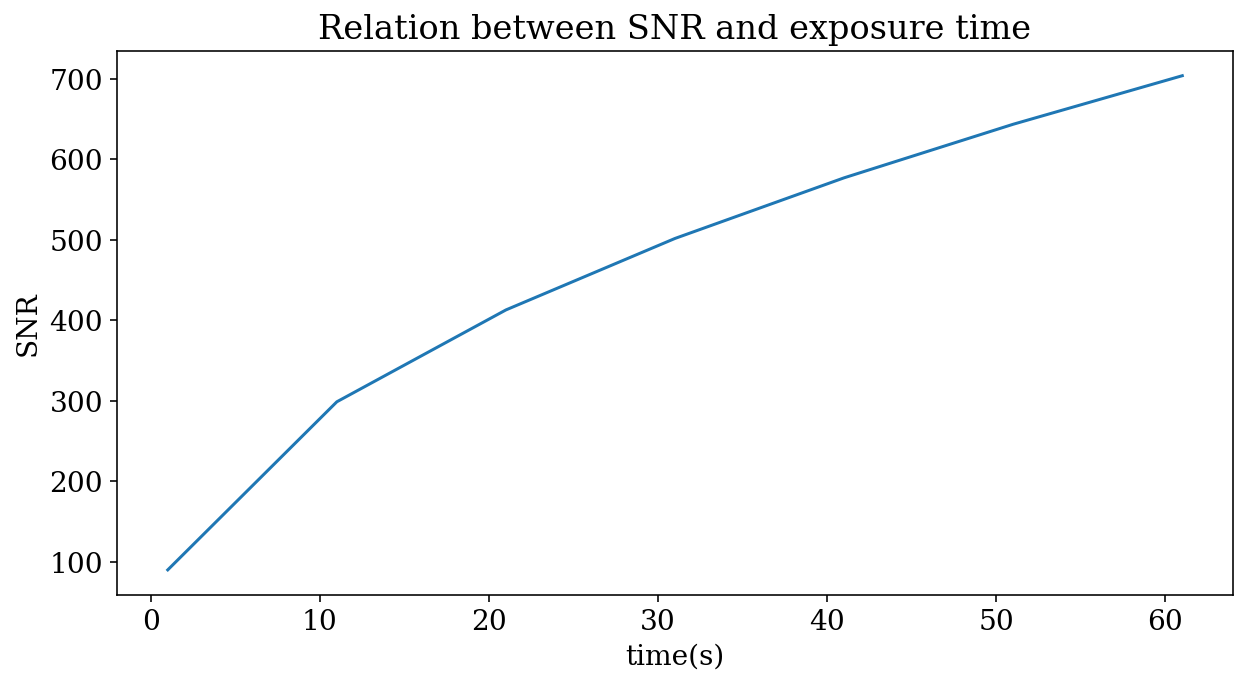

In [25]:
t=np.arange(1, 70, 10)
n = 2.166 * 10**3
S_B = 0.1
C_D = 0.2

SNR = S*t / np.sqrt(S*t + n*t*(S_B + C_D))

plt.xlabel('time(s)')
plt.ylabel('SNR')
plt.title('Relation between SNR and exposure time')
plt.plot(t, SNR)

### Average magnitude

In [26]:
S = electron_rate_ADU(m_avg)
print(S)

3.7050996357764143


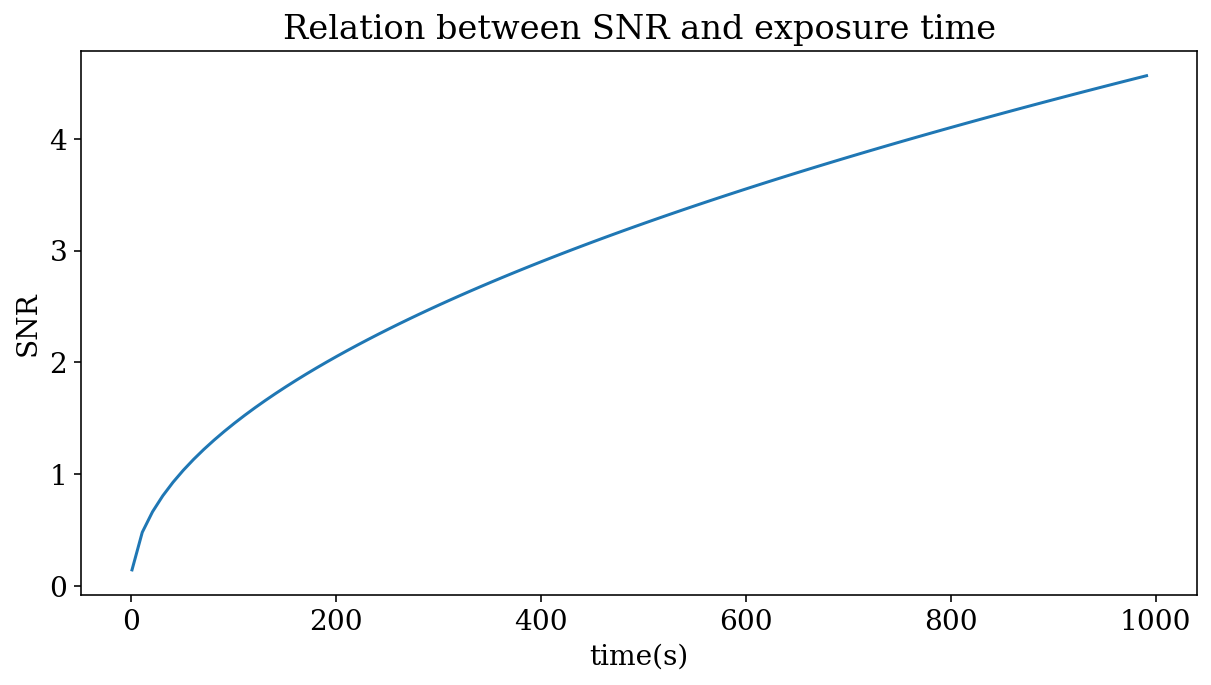

In [27]:
t=np.arange(1, 1000, 10)
n = 2.166 * 10**3
S_B = 0.1
C_D = 0.2

SNR = S*t / np.sqrt(S*t + n*t*(S_B + C_D))

plt.xlabel('time(s)')
plt.ylabel('SNR')
plt.title('Relation between SNR and exposure time')
plt.plot(t, SNR)

# Data analysis

In [28]:
#function to open files

def read_files(file_names):
    data = []
    
    for file in file_names:
        myfile = fits.open(file)
        data.append(myfile[0].data)
        myfile.close()
        
    return data

##   Bias frame


In [29]:
# read the files

bias_names = glob.glob('../work/20221018/calib_0*bias*')

bias1 = fits.open(bias_names[0])
data1 = bias1[0].data
header1 = bias1[0].header
bias1.close()

print(bias1.info())
print(header1)

Filename: ../work/20221018\calib_033bias.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      25   (4499, 3599)   uint16   
None
SIMPLE  =                    T                                                  BITPIX  =                   16                                                  NAXIS   =                    2                                                  NAXIS1  =                 4499                                                  NAXIS2  =                 3599                                                  BZERO   =           32768.000000                                                BSCALE  =             1.000000                                                  DATAMIN =             0.000000                                                  DATAMAX =           65535.000000                                                INSTRUME=           'ATIK-16200: fw rev 3.52'                                   FILTER  =           '

Shape of stack (15, 3599, 4499)
Shape of array (3599, 4499)


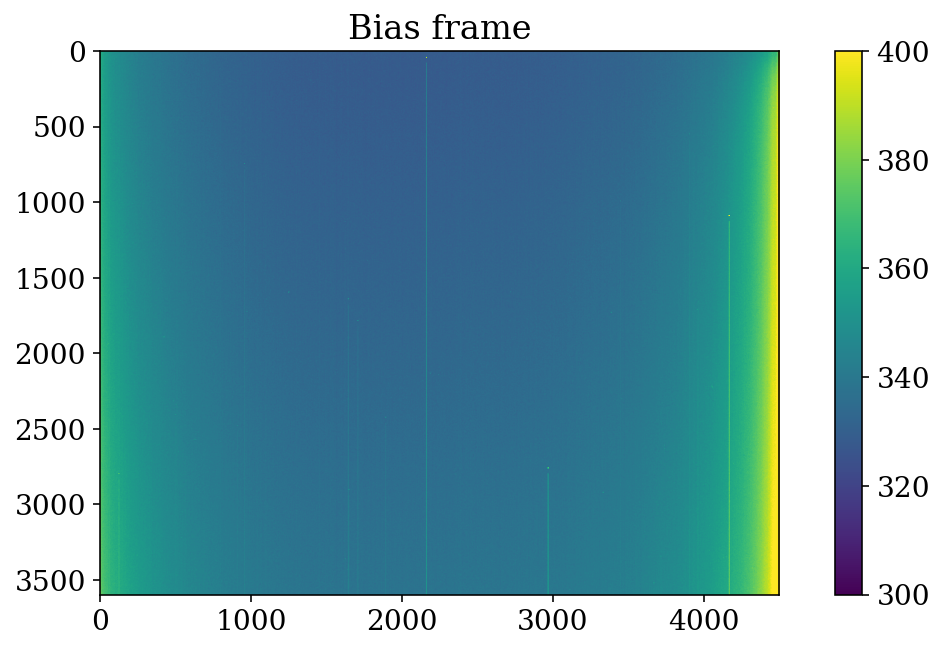

In [34]:
all_bias = read_files(bias_names)

all_bias = np.array(all_bias)
print('Shape of stack', all_bias.shape)

meanbias = np.mean(all_bias, axis=0)
print('Shape of array', meanbias.shape)

plt.clf()
plt.imshow(meanbias, clim=[300,400])
plt.title('Bias frame')
plt.colorbar()

In [ ]:
# save as a fits file the bias
hdu_bias = fits.PrimaryHDU(meanbias)
hdul_bias = fits.HDUList([hdu_bias])
hdul_bias.writeto('mean_bias.fits')

## Dark Current

## Flat frame

In [66]:
def filter_reduction(data):
    # subtract the bias:
    data_nb = data - meanbias
    
    # take the average of the data without the bias:
    flat_nb = np.mean(data_nb, axis=0) 
        
    #take the median of the values:
    flat_median = np.median(flat_nb)
        
    #normalize dividing by the median:
    norm_flat_nb = flat_nb / flat_median
        
    return norm_flat_nb
    

### Ha filter:

In [67]:
# H_alpha
flat_Halpha_names = glob.glob('../work/20221018/flat_*Halpha*')
all_flatHa = read_files(flat_Halpha_names)
all_flatHa = np.array(all_flatHa)
print('Stack shape: ', all_flatHa.shape)

Stack shape:  (5, 3599, 4499)


min: 0.7914073108894105
max: 2.8014466361588393


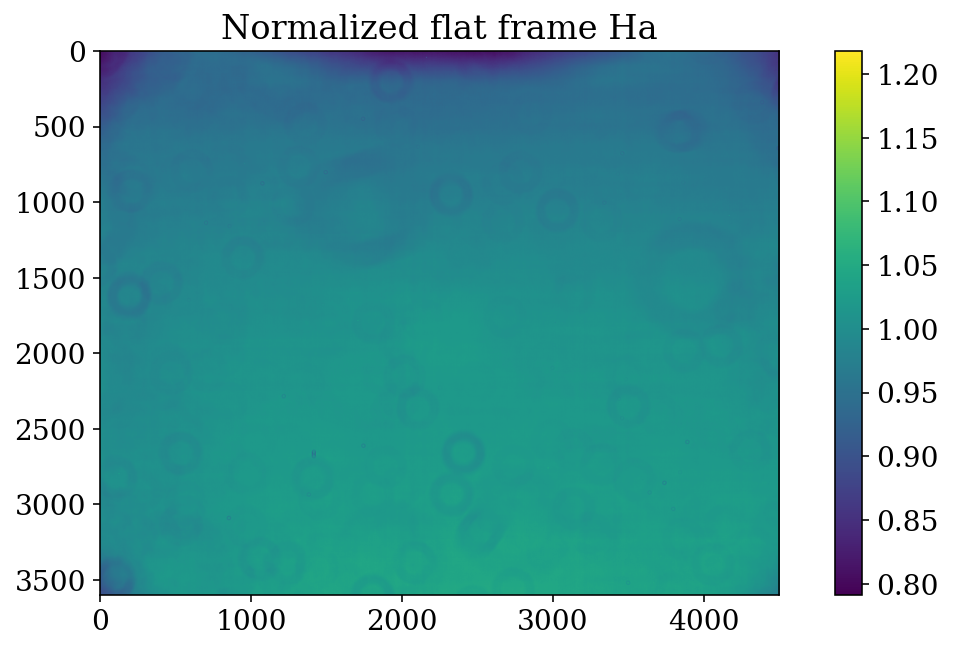

In [68]:
norm_flatHa = filter_reduction(all_flatHa)

#plot:
print('min:', np.min(norm_flatHa))
print('max:', np.max(norm_flatHa) )

plt.clf()
plt.title('Normalized flat frame Ha')
plt.imshow(norm_flatHa, clim=[np.min(norm_flatHa), np.max(norm_flatHa)/2.3])
plt.colorbar()

In [ ]:
#create fits file:

hdu_norm_flatHa = fits.PrimaryHDU(norm_flatHa)
hdul_norm_flatHa = fits.HDUList([hdu_norm_flatHa])
hdul_norm_flatHa.writeto('norm_flatHa.fits')

### OIII filter

In [69]:
#OIII
flat_OIII_names = glob.glob('../work/20221018/flat_*OIII*')
all_flatOIII = read_files(flat_OIII_names)
all_flatOIII = np.array(all_flatOIII)
print('Stack shape: ', all_flatOIII.shape)

Stack shape:  (5, 3599, 4499)


min: 0.6984858918999403
max: 3.2367945949970216


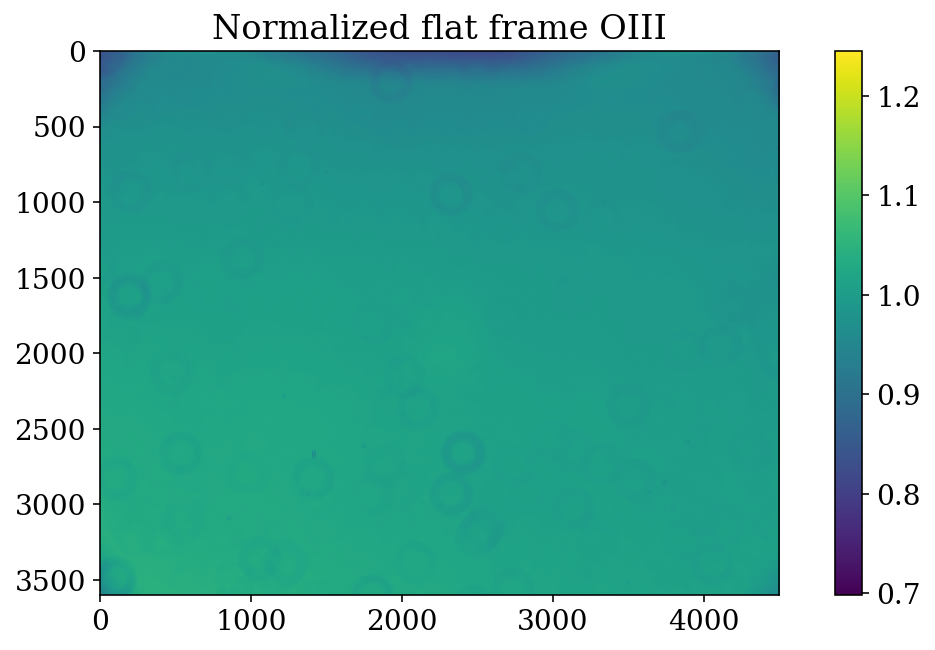

In [70]:
norm_flatOIII = filter_reduction(all_flatOIII)

#plot
print('min:', np.min(norm_flatOIII))
print('max:', np.max(norm_flatOIII) )

plt.clf()
plt.title('Normalized flat frame OIII')
plt.imshow(norm_flatOIII, clim=[np.min(norm_flatOIII), np.max(norm_flatOIII)/2.6])
plt.colorbar()

In [ ]:
#create fits file:

hdu_norm_flatOIII = fits.PrimaryHDU(norm_flatOIII)
hdul_norm_flatOIII = fits.HDUList([hdu_norm_flatOIII])
hdul_norm_flatOIII.writeto('norm_flatOIII.fits')

### SII filter

In [71]:
#SII
flat_SII_names = glob.glob('../work/20221018/flat_*SII*')
all_flatSII = read_files(flat_SII_names)
all_flatSII = np.array(all_flatSII)
print('Stack shape: ', all_flatSII.shape)

Stack shape:  (5, 3599, 4499)


min: 0.793740434065538
max: 2.986445521340778


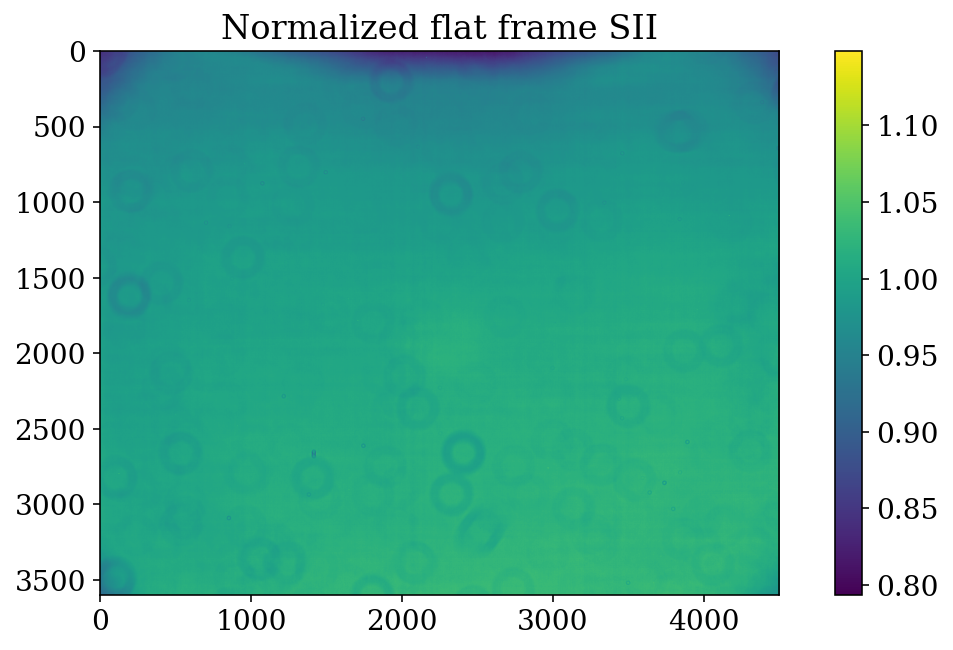

In [72]:
norm_flatSII = filter_reduction(all_flatSII)

#plot
print('min:', np.min(norm_flatSII))
print('max:', np.max(norm_flatSII) )

plt.clf()
plt.title('Normalized flat frame SII')
plt.imshow(norm_flatSII, clim=[np.min(norm_flatSII), np.max(norm_flatSII)/2.6])
plt.colorbar()

In [ ]:
#create fits file:

hdu_norm_flatSII = fits.PrimaryHDU(norm_flatSII)
hdul_norm_flatSII = fits.HDUList([hdu_norm_flatSII])
hdul_norm_flatSII.writeto('norm_flatSII.fits')

## Data

In [83]:
def naming_data(init_data_names):
    data_names = []
    for i in range(len(init_data_names)):
        names = init_data_names[i].split('/')[-1]
        names = names.split('\\')[-1]
        names = names.split('.')[0]
        data_names.append(names)
    
    return data_names

In [84]:
def get_time(data_names):
    exp_time = []
    for i in range(len(data_names)):
        time = data_names[i].split('_')[-1]
        time = time.split('s')[0]
        time = float(time)
        exp_time.append(time)
    
    return exp_time

In [88]:
def get_gain(data, exp_time):
    data_gain = []
    for i, time in zip(np.arange(len(data)), exp_time):
        dg = data[i]*0.6 / time
        data_gain.append(dg)
        
    return data_gain

In [110]:
def data_reduction(data, filter_name, data_names):
    #subtract the bias:
    data_nb = data - meanbias
    
    #get the exposure time:
    exp_time = get_time(data_names)
    
    #different path depending on the filter
    
    if (filter_name == 'Halpha'):
        #divide by the flat
        dataHa_clean = data_nb / norm_flatHa
        
        #consider the gain (conversion ADU->e/sec):
        dataHa_gain = get_gain(dataHa_clean, exp_time)
        
        return dataHa_gain
    
    if (filter_name =='OIII'):
        #divide by the flat:
        dataOIII_clean = data_nb / norm_flatOIII
        
        #consider the gain
        dataOIII_gain = get_gain(dataOIII_clean, exp_time)
        
        return dataOIII_gain
    
    if (filter_name == 'SII'):
        #divide by the flat:
        dataSII_clean = data_nb / norm_flatSII
        
        #consider the gain
        dataSII_gain = get_gain(dataSII_clean, exp_time)
        
        return dataSII_gain
        
    else: return 0

### Ha filter 

Stack shape:  (4, 3599, 4499)
['NGC956_021Halpha_120s', 'NGC956_021Halpha_300s', 'NGC956_022Halpha_120s', 'NGC956_023Halpha_300s']


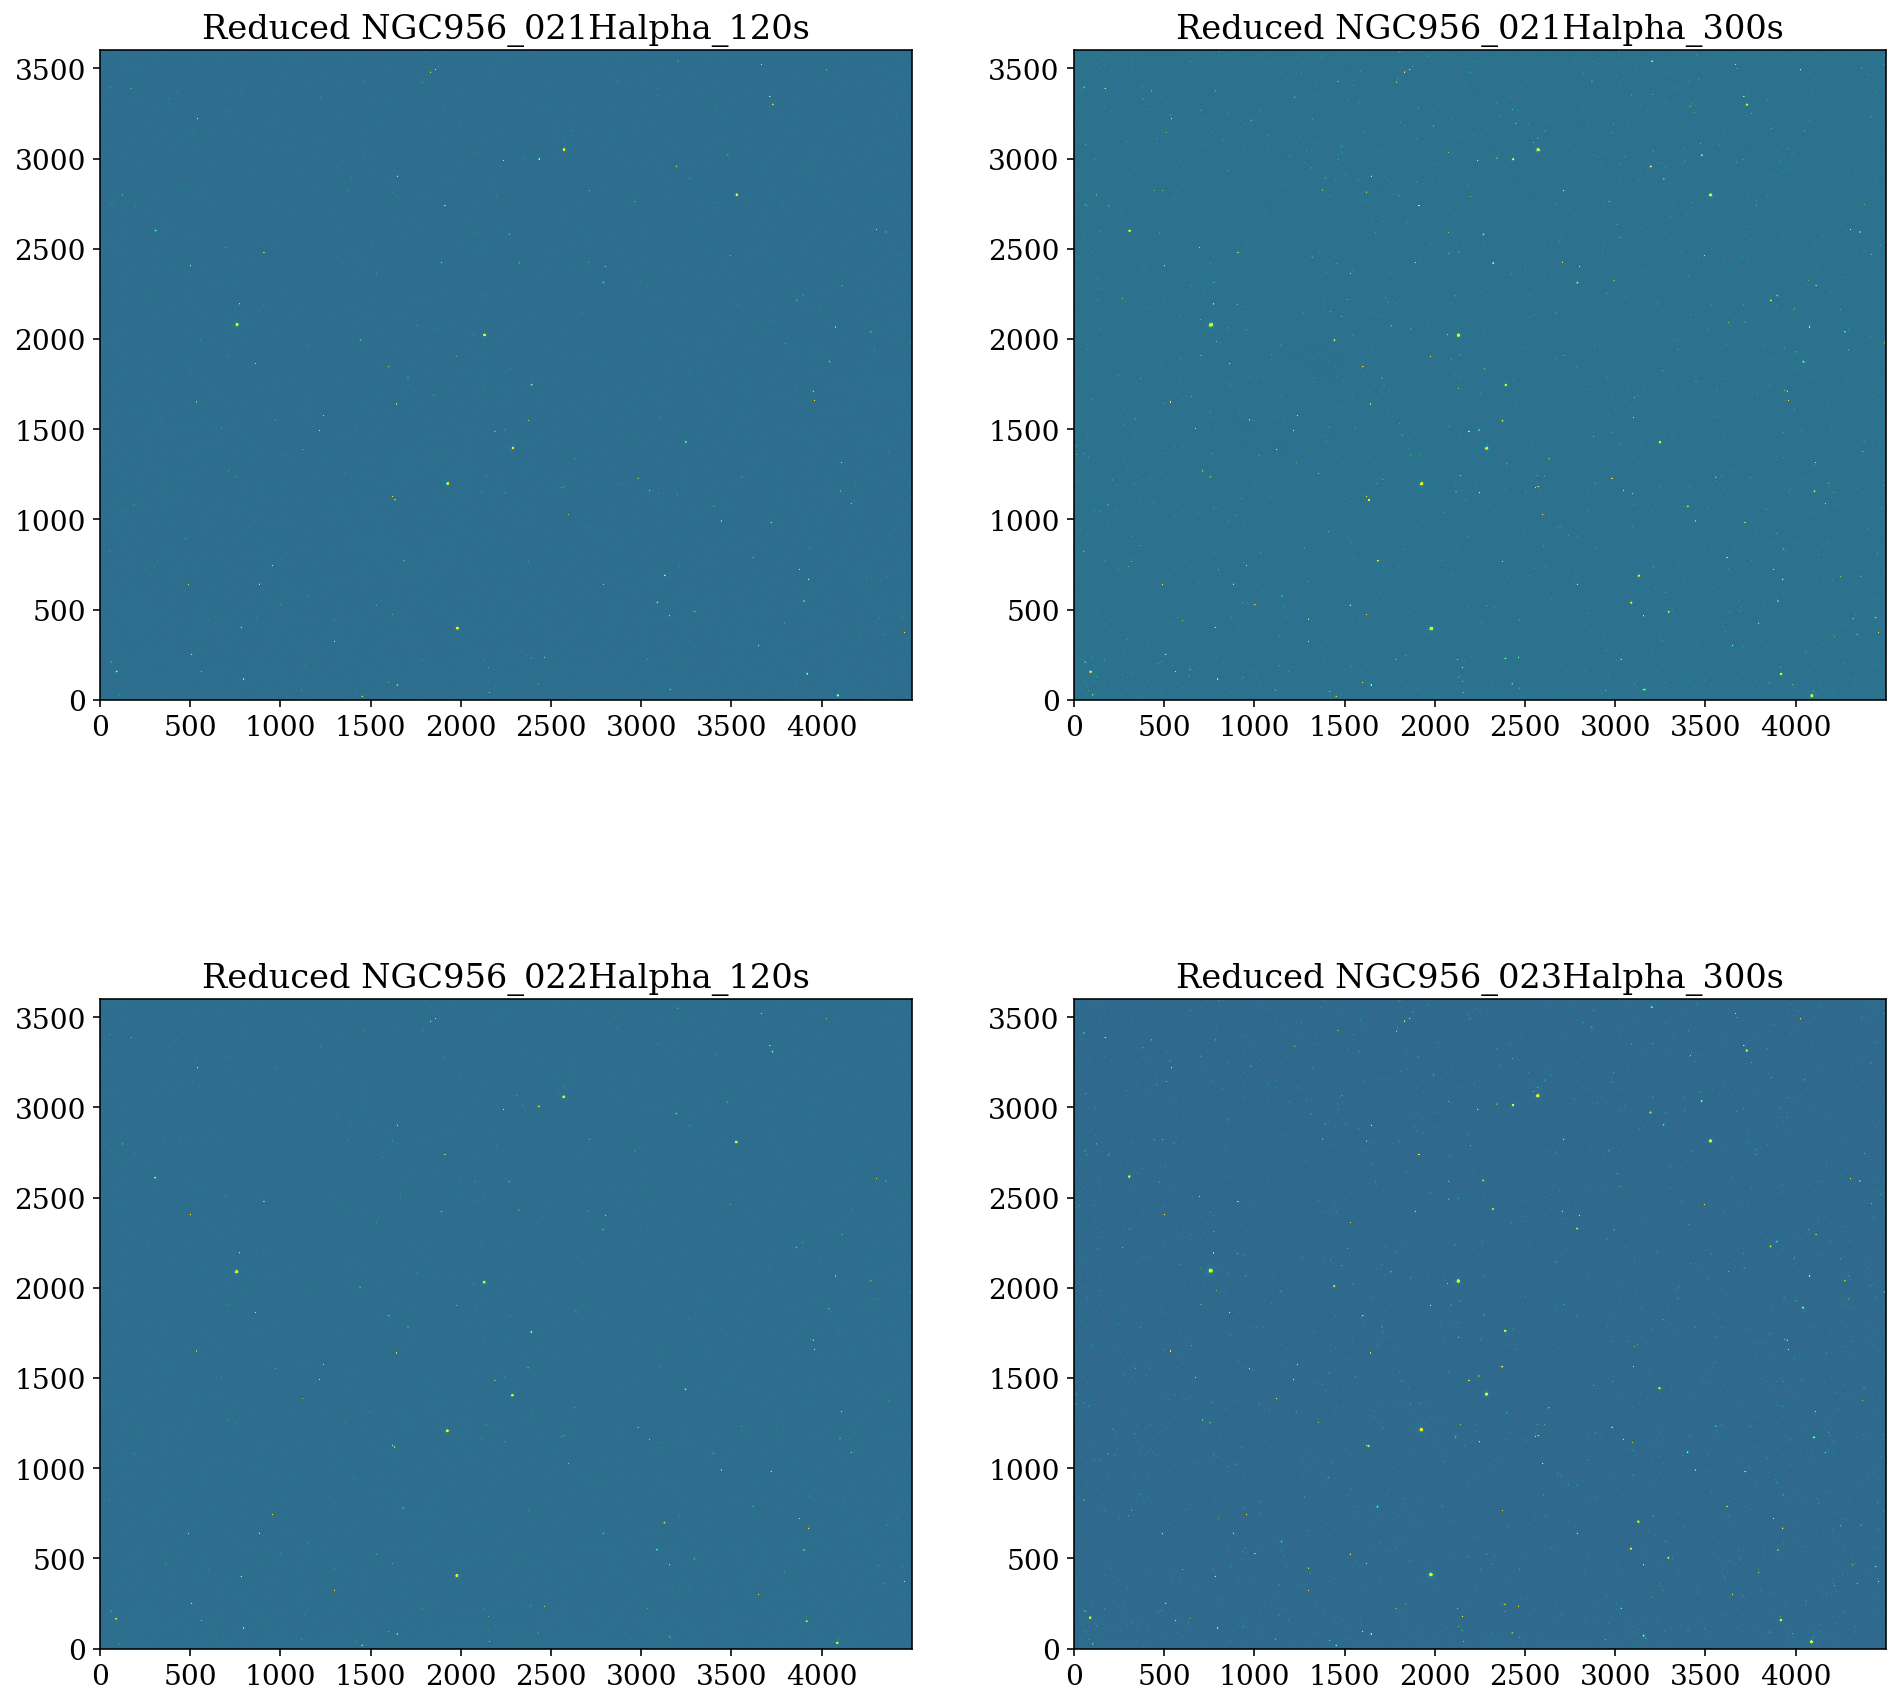

In [115]:
#Halpha filter

#reading data
data_Halpha_names = glob.glob('../work/20221018/NGC956*Halpha*')
all_dataHa = read_files(data_Halpha_names)
all_dataHa = np.array(all_dataHa)
print('Stack shape: ', all_dataHa.shape)

names_dataHa = naming_data(data_Halpha_names)
print(names_dataHa)

reduced_dataHa = data_reduction(all_dataHa, 'Halpha', names_dataHa)

#plot

nrows = 2
ncols = 2

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16,16))

for i, names in zip(np.arange(4), names_dataHa):
    
    ax = ax.ravel()
    
    #ax[i].clf()
    ax[i].set_title('Reduced '+names)
    ax[i].set_ylim(0,3599)
    ax[i].imshow(reduced_dataHa[i], clim=[np.min(reduced_dataHa[i]), np.max(reduced_dataHa[i])/70])
    
    

In [99]:
#create fits file:

for i, names in zip(np.arange(len(reduced_dataHa)), names_dataHa):
    hdu_dataHa_reduced = fits.PrimaryHDU(reduced_dataHa[i])
    hdul_dataHa_reduced = fits.HDUList([hdu_dataHa_reduced])
    hdul_dataHa_reduced.writeto('Reduced_'+ names + '.fits')

### OIII filter

Stack shape:  (4, 3599, 4499)
['NGC956_021OIII_120s', 'NGC956_021OIII_300s', 'NGC956_023OIII_120s', 'NGC956_023OIII_300s']


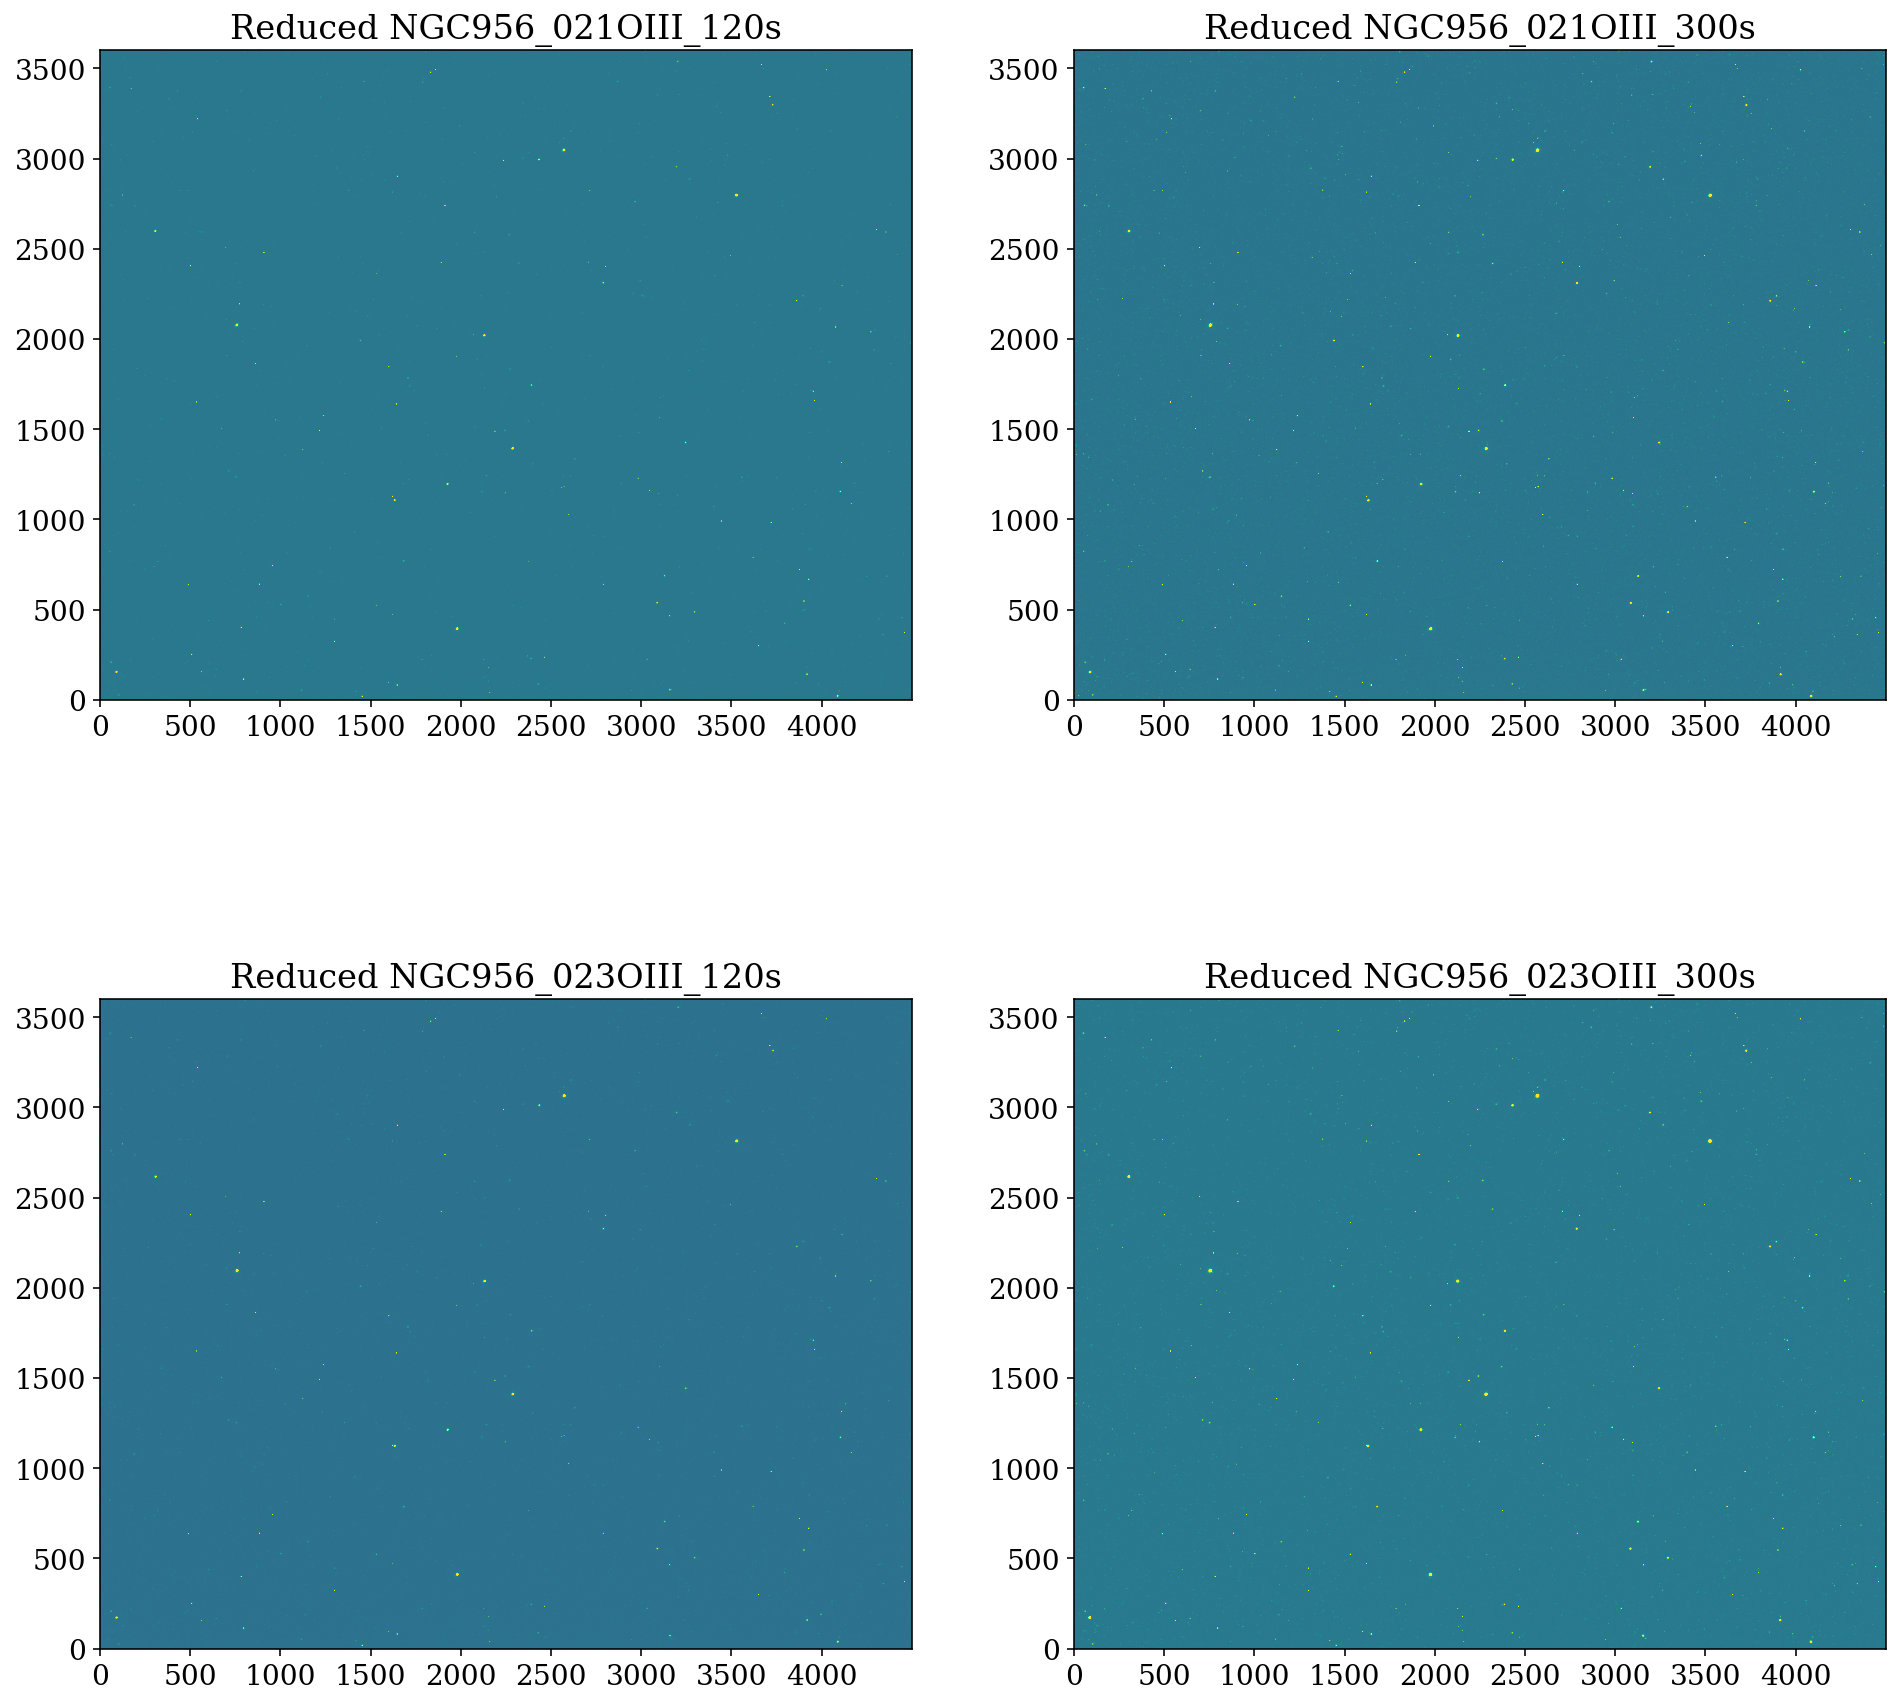

In [103]:
#OIII filter:

#reading data
data_OIII_names = glob.glob('../work/20221018/NGC956*OIII*')
all_dataOIII = read_files(data_OIII_names)
all_dataOIII = np.array(all_dataOIII)
print('Stack shape: ', all_dataOIII.shape)

names_dataOIII = naming_data(data_OIII_names)
print(names_dataOIII)

reduced_dataOIII = data_reduction(all_dataOIII, 'OIII', names_dataOIII)

#plot

nrows = 2
ncols = 2

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16,16))

for i, names in zip(np.arange(4), names_dataOIII):
    
    ax = ax.ravel()
    
    #ax[i].clf()
    ax[i].set_title('Reduced '+names)
    ax[i].set_ylim(0,3599)
    ax[i].imshow(reduced_dataOIII[i], clim=[np.min(reduced_dataOIII[i]), np.max(reduced_dataOIII[i])/70])

In [104]:
#create fits file:

for i, names in zip(np.arange(len(reduced_dataOIII)), names_dataOIII):
    hdu_dataOIII_reduced = fits.PrimaryHDU(reduced_dataOIII[i])
    hdul_dataOIII_reduced = fits.HDUList([hdu_dataOIII_reduced])
    hdul_dataOIII_reduced.writeto('Reduced_'+ names + '.fits')

### SII filter

Stack shape:  (4, 3599, 4499)
['NGC956_021SII_120s', 'NGC956_021SII_300s', 'NGC956_023SII_120s', 'NGC956_023SII_300s']


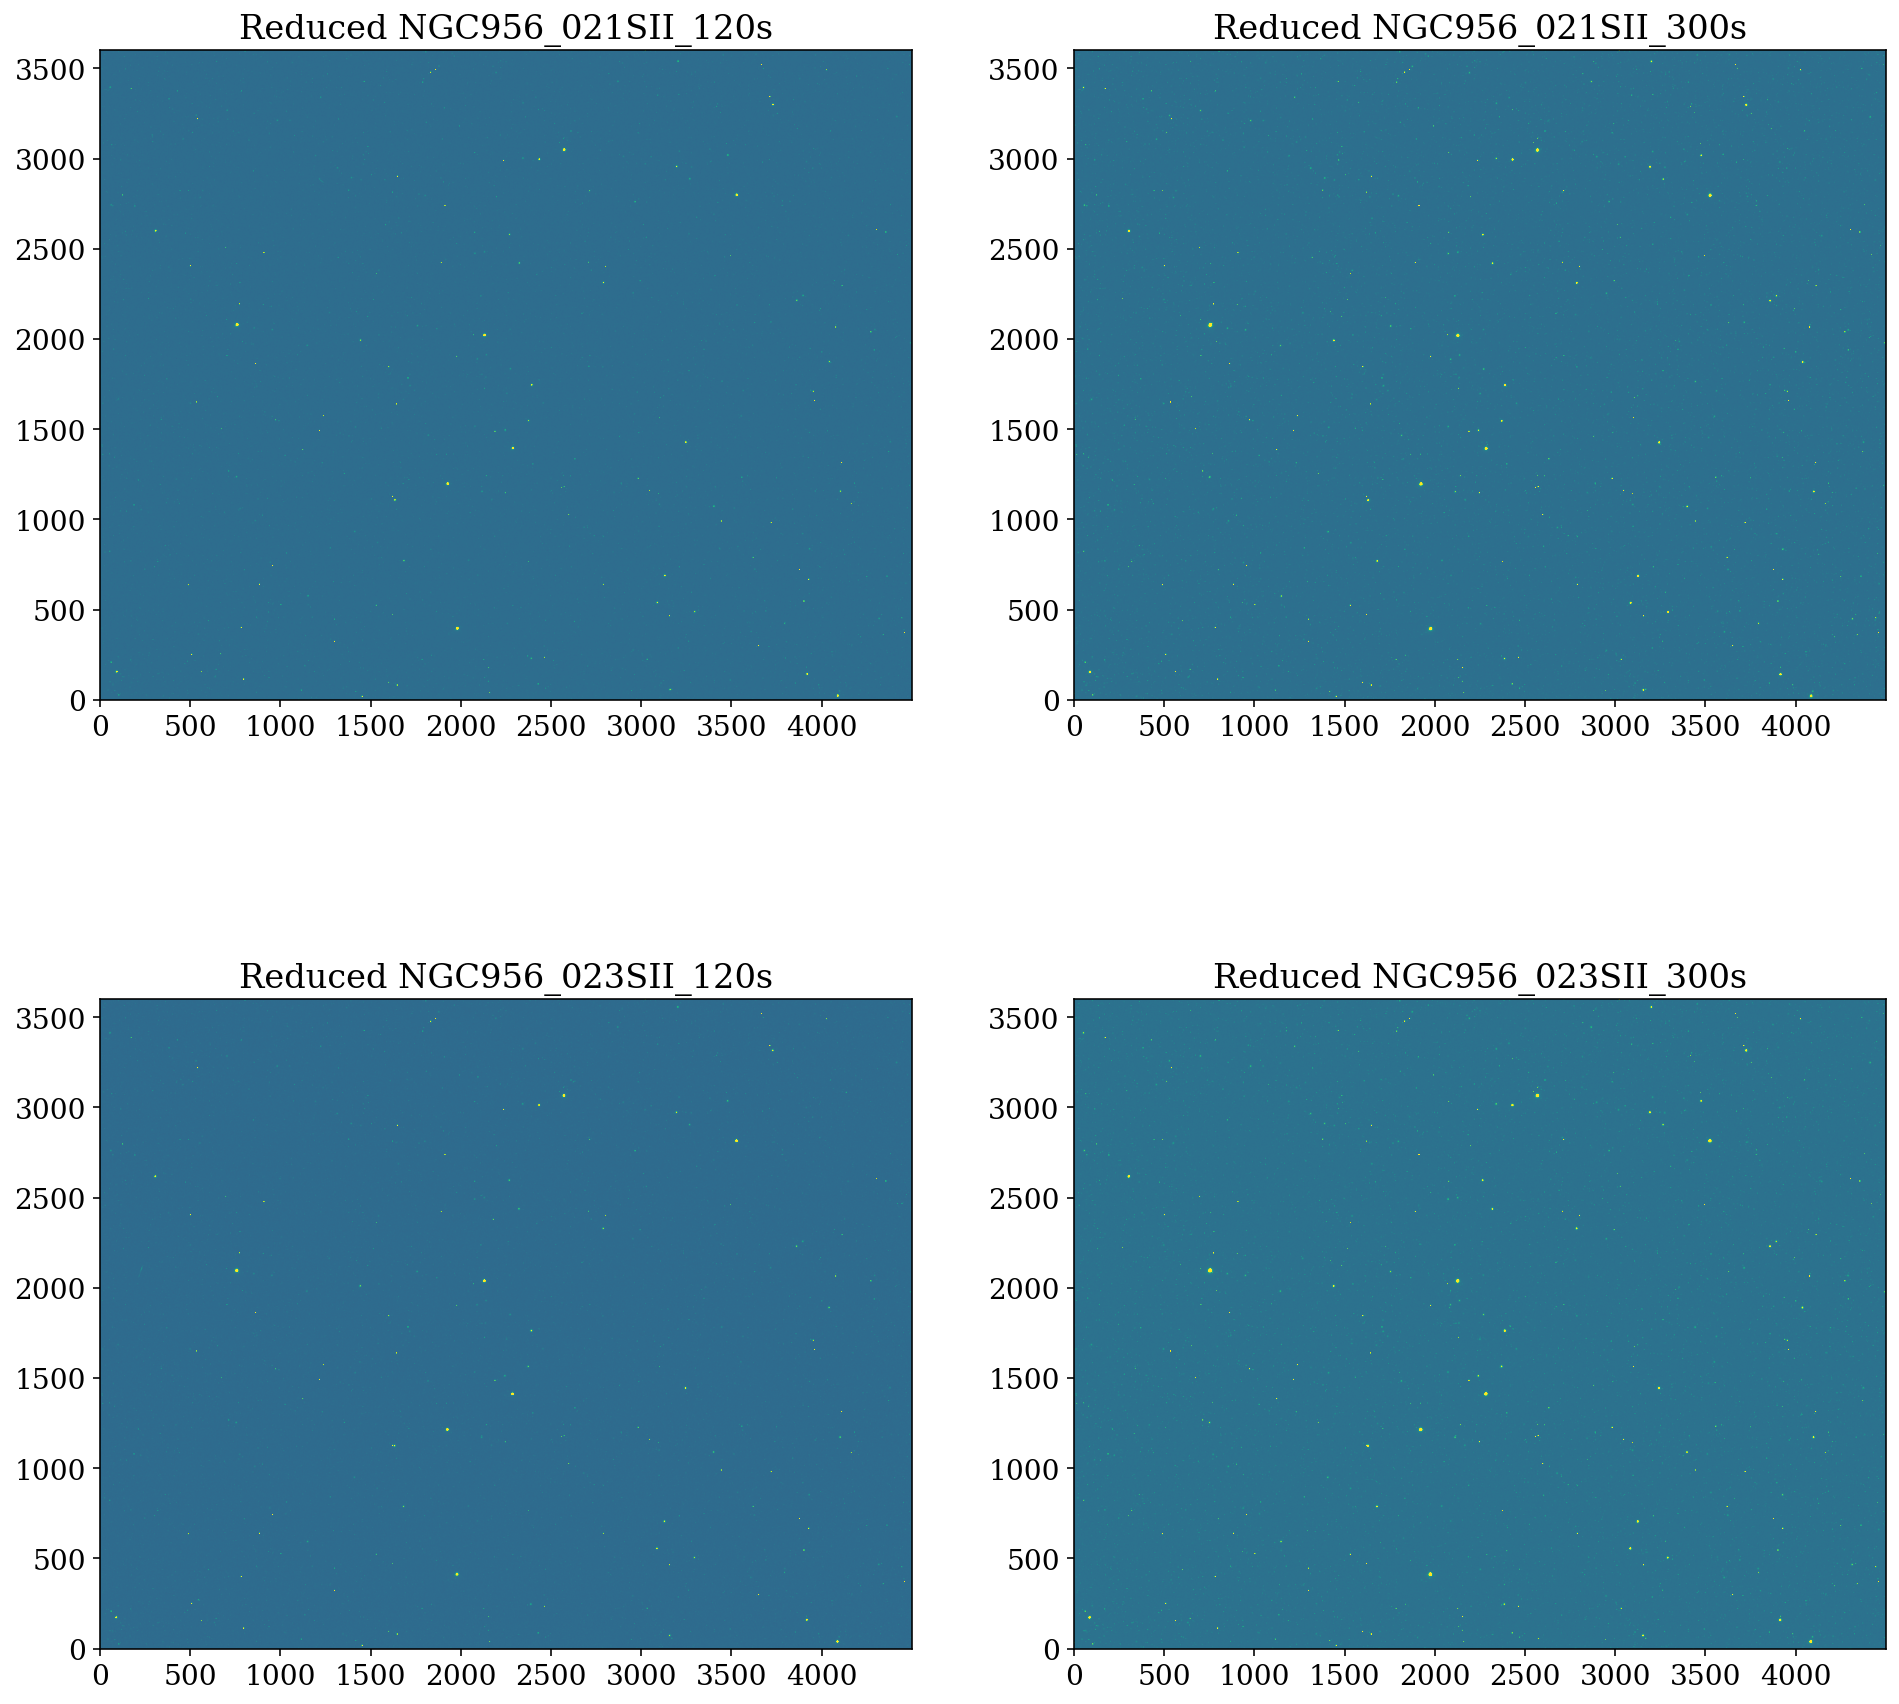

In [112]:
#SII filter:

#reading data
data_SII_names = glob.glob('../work/20221018/NGC956*SII*')
all_dataSII = read_files(data_SII_names)
all_dataSII = np.array(all_dataSII)
print('Stack shape: ', all_dataSII.shape)

names_dataSII = naming_data(data_SII_names)
print(names_dataSII)

reduced_dataSII = data_reduction(all_dataSII, 'SII', names_dataSII)

#plot

nrows = 2
ncols = 2

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16,16))

for i, names in zip(np.arange(4), names_dataSII):
    
    ax = ax.ravel()
    
    #ax[i].clf()
    ax[i].set_title('Reduced '+names)
    ax[i].set_ylim(0,3599)
    ax[i].imshow(reduced_dataSII[i], clim=[np.min(reduced_dataSII[i]), np.max(reduced_dataSII[i])/70])

In [116]:
#create fits file:

for i, names in zip(np.arange(len(reduced_dataSII)), names_dataSII):
    hdu_dataSII_reduced = fits.PrimaryHDU(reduced_dataSII[i])
    hdul_dataSII_reduced = fits.HDUList([hdu_dataSII_reduced])
    hdul_dataSII_reduced.writeto('Reduced_'+ names + '.fits')

## Calibration of the standard star

In [118]:
# Halpha filter

std_Halpha_names = glob.glob('../work/20221018/HD3360*Halpha*')
all_stdHa = read_files(std_Halpha_names)
all_stdHa = np.array(all_stdHa)
print('Stack shape: ', all_stdHa.shape)

#subtract the bias
all_stdHa_nb = all_stdHa - meanbias

#divide by the normalized flat
all_stdHa_clean = all_stdHa_nb / norm_flatHa


names_stdHa = []
for i in range (len(std_Halpha_names)):
    names = std_Halpha_names[i].split('/')[-1]
    names = names.split('\\')[-1]
    names = names.split('.')[0]
    names_stdHa.append(names + '_clean')
    
print(names_stdHa)

Stack shape:  (5, 3599, 4499)
['HD3360_010Halpha_clean', 'HD3360_011Halpha_clean', 'HD3360_012Halpha_clean', 'HD3360_013Halpha_clean', 'HD3360_014Halpha_clean']


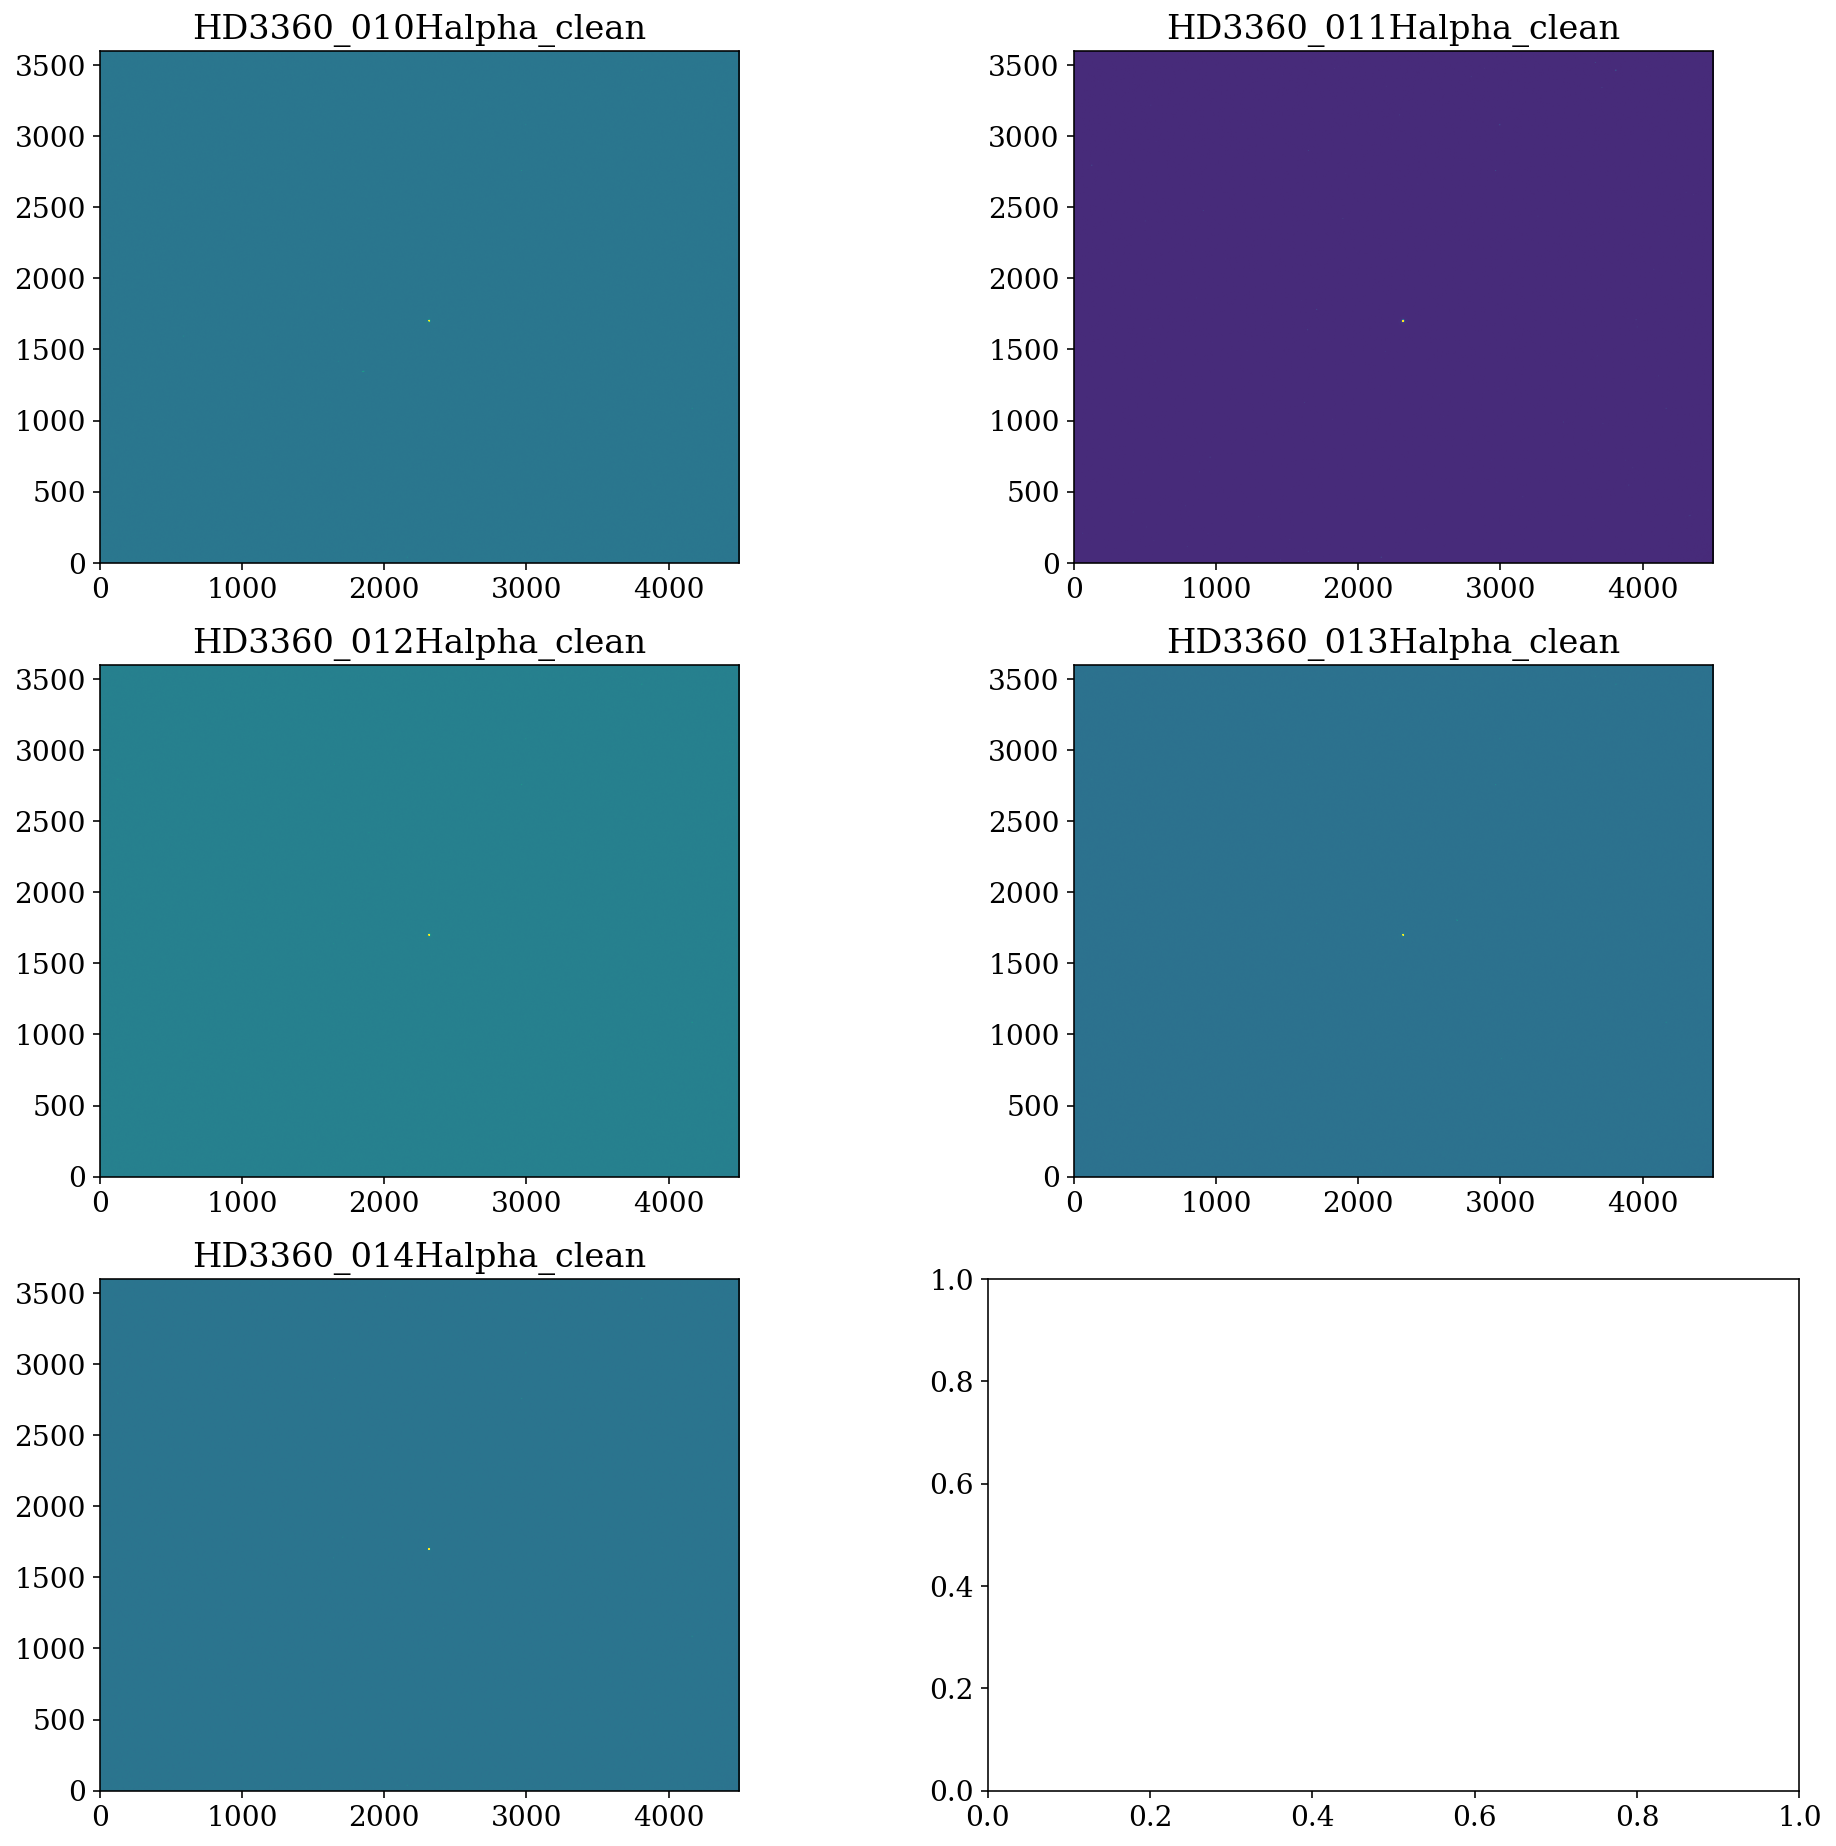

In [119]:
nrows = 3
ncols = 2

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16,16))

for i, names in zip(np.arange(len(names_stdHa)), names_stdHa):
    
    ax = ax.ravel()
    
    #ax[i].clf()
    ax[i].set_title(names)
    ax[i].set_ylim(0,3599)
    ax[i].imshow(all_stdHa_clean[i], clim=[np.min(all_stdHa_clean[i]), np.max(all_stdHa_clean[i])/20])